# 8.1. Audio Classification

In this notebook, we will learn how to perform a simple speech classification using `torchaudio`. This is similar to the image classification problem, in which the network's task is to assign a label to the given image but in audio files.

The audio and visual signals, in simplest form, differ in the following aspects:
* A visual signal (image) has a spatial resolution ($width \times height$), essentially a 2D matrix. Of course, often, the signal consists of three colour channels (i.e., a third dimension), and if it is a video, it has a fourth dimension (temporal axis).
* An audio signal does not have a spatial resolution spanning only over time (i.e., 1D signal). Of course, often, the signal consists of several stereo channels (i.e., a second dimension).

## 0. Preparation

In order to run this notebook, we need to perform some preparations.

### Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [IPython.display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html) is a library to display tools in IPython.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt
import IPython.display as ipd

import torch
import torch.nn as nn
import torchaudio

### Device
Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Selected device:', device)

Selected device: cuda


## 1. Dataset

The [torchaudio.dataset](https://pytorch.org/audio/stable/datasets.html) offers easy access
to several audio datasets. We use the `SPEECHCOMMANDS` datasets but a modified version that
is much smaller. We have created a [**TinySpeechCommand**](https://www.dropbox.com/s/4p46txh2kj16tb7/TinySpeechCommands.tar.gz?dl=0) dataset
that is similar to the [MNIST](http://yann.lecun.com/exdb/mnist/) but in audio files:
speech recognition of spoken digits from 0 to 9.

In the *TinySpeechCommand* dataset, all audio files are about 1 second long (and
so about 16000-time frames long).

To load our dataset:
* We create a `TinySpeechCommand` `class` that inherits the `torchaudio.datasets.SPEECHCOMMANDS`.
* We only change the `__init__` function to link to correct URL and available sets (training/validation)


In [3]:
def _load_list(root, *filenames):
    """Loads the txt files of our dataset"""
    output = []
    for filename in filenames:
        filepath = os.path.join(root, filename)
        with open(filepath) as fileobj:
            output += [os.path.normpath(os.path.join(root, line.strip())) for line in fileobj]
    return output

class TinySpeechCommand(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, split):
        super().__init__(
            "./data/", download=True, 
            url='https://dl.dropboxusercontent.com/s/4p46txh2kj16tb7/TinySpeechCommands.tar.gz'
        )
        if split == "validation":
            self._walker = _load_list(self._path, "validation_list.txt")
        elif split == "training":
            excludes = set(_load_list(self._path, "validation_list.txt"))
            self._walker = [w for w in self._walker if w not in excludes]

### Train/test sets

We create two sets for training and testing. In this tutorial, we don't use a validation set. 
The first time you execute the following cell, it downloads the dataset and extracts its content
in the `./data/` directory.

In [4]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_db = TinySpeechCommand("training")
test_db = TinySpeechCommand("validation")

### Sample audios
A data point in our dataset is a tuple of five elements:
* waveform (the audio signal)
* the sample rate,
* the utterance (label)
* the ID of the speaker
* the trial number of the utterance.

Let's open the first element (by using the `__getitem__` function) and plot the wave.

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000
The utterance (label): eight
The ID of the speaker: 004ae714
The trial number of the utterance: 0


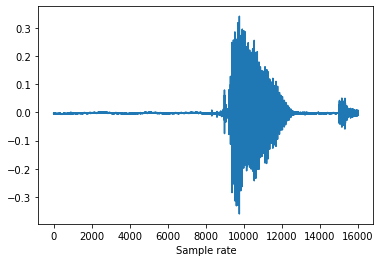

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_db.__getitem__(0)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("The utterance (label): {}".format(label))
print("The ID of the speaker: {}".format(speaker_id))
print("The trial number of the utterance: {}".format(utterance_number))

plt.plot(waveform.t().numpy())
plt.xlabel('Sample rate')
plt.show()

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_db)))
print(labels)

['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']


The 10 audio labels are commands that are said by users. The first few files are people 
saying "eight". We can use `ipd.Audio` to play back the audio file in our notebook.


In [7]:
waveform_first, *_ = train_db[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

The last file is someone saying "zero".

In [8]:
waveform_last, *_ = train_db[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

### Transform functions

We downsample the audio signal for faster processing without losing
too much of the classification power. We use the `torchaudio.transforms.Resample` function.

We don't need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (e.g., from
stereo to mono). The dataset we study in this notebook, *TinySpeechCommands*
uses a single channel for audio, this is not needed here.

In [9]:
new_sample_rate = 8000
resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

Let's try to resample one audio file to check its quality.

In [10]:
waveform_transformed = resample_transform(waveform)
print("Shape of resamples waveform: {}".format(waveform_transformed.size()))
ipd.Audio(waveform_transformed.numpy(), rate=new_sample_rate)

Shape of resamples waveform: torch.Size([1, 8000])


### Utility functions

We are encoding each word using its index in the list of labels.

In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "zero"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

zero --> tensor(9) --> zero


### Dataloaders

The sampling rate of all audio files is not exactly 16000, some are a bit less or more.
This would cause an issue in creating the batch data (i.e., several audio files). To create a `tensor` variable, all elements must have the same size. To overcome this,
we pad the audio with zeros to equalise all audio signals in a batch. This is implemented as follows:
* We create "custom" batches by passing `collate_fn=collate_fn` to `torch.utils.data.DataLoader` (for more details check its [documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)).
* We implement the `collate_fn` that extracts two elements of our dataset tuple (i.e., waveform and label).
* We pass the list of audio waveforms to  `pad_sequence` which makes them of identical size.
* In the `collate_fn`, we also apply the resampling and the text encoding.

In [12]:
def pad_sequence(batch):
    # Make all tensors in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    audios, targets = [], []
    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        audios.append(resample_transform(waveform))
        targets.append(label_to_index(label))

    # Group the list of tensors into a batched tensor
    audios = pad_sequence(audios)
    targets = torch.stack(targets)
    return audios, targets

Finally, let's create the train/test dataloaders.

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_db,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=False,
)

## 2. Network

For this tutorial, we will use a simple convolutional neural network (CNN)
`AudioClassificationNet` to process the raw audio data. Usually, more advanced 
transforms are applied to the audio data, however, this is beyond the scope of
this notebook and the speech command classification we want to solve here.

The specific architecture is modelled after the network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf). Characteristics
of our architecture:
* It uses `nn.Conv1d` and `nnMaxPool1d` in comparison to the 2D versions we used for image classification.
* It consists of four blocks (convolution, batch normalisation, rectification and pooling).
* An important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is the length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms).
* Finally, we have a classification layer `nn.Linear` with 10 output nodes.

In [14]:
class AudioClassificationNet(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        # block 1
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(4)
        # block 2
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(4)
        # block 3
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(4)
        # block 4
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(4)
        # classifiction layer
        self.fc = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        x = self.pool4(x)
        x = torch.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        return x

Let's make an instance of this model and print it's parameters.

In [15]:
model = AudioClassificationNet(n_input=waveform_transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_model_parameters = count_parameters(model)
print("Number of parameters: %s" % num_model_parameters)

AudioClassificationNet(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dila

## 3. Train/test routines

The following routines are very similar (close to identical) to what we previously
saw in the image classification problem.

In [16]:
def epoch_loop(model, dataloader, criterion, optimiser, log_frequency=10):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()

    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (audios, target) in enumerate(dataloader):
            # print(audios.shape, target.shape)
            audios = audios.to(device)
            target = target.to(device)
    
            output = model(audios)
    
            # negative log-likelihood for a tensor of size (batch x 1 x n_output)
            loss = criterion(output.squeeze(), target)
            losses.extend([loss.item() for _ in range(audios.size(0))])

            # computing the accuracy
            acc = (output.argmax(dim=-1).squeeze() == target).sum() / audios.size(0)
            accuracies.extend([acc.item() for _ in range(audios.size(0))])
    
            if batch_ind % log_frequency == 0 and batch_ind > 0:
                print(
                    '%s batches [%.5d/%.5d] \tloss=%.4f\tacc=%0.2f' % (
                        'training' if is_train else 'testing', batch_ind,
                        len(dataloader), np.mean(losses), np.mean(accuracies)
                    )
                )

            if is_train:
                # compute gradient and do SGD step
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
    return accuracies, losses

Finally, we can train and test the network. We will train the network
for ten epochs. The network reached close to $80\%$ accuracy on the test set.

In [17]:
# Hyperparameters
initial_epoch = 0
epochs = 10
lr = 0.01

model = AudioClassificationNet(n_input=waveform_transformed.shape[0], n_output=len(labels)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    print('Epoch [%.2d]' % epoch)
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    val_log = epoch_loop(model, test_loader, criterion, None)
    
    print('Train     loss=%.4f     acc=%0.2f    Test     loss=%.4f     acc=%0.2f' % 
          (
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

Epoch [00]
training batches [00010/00018] 	loss=2.1417	acc=0.24
testing batches [00010/00016] 	loss=2.2838	acc=0.20
Train     loss=1.9794     acc=0.29    Test     loss=2.5052     acc=0.14
Epoch [01]
training batches [00010/00018] 	loss=1.3666	acc=0.51
testing batches [00010/00016] 	loss=1.2995	acc=0.54
Train     loss=1.3160     acc=0.53    Test     loss=1.3089     acc=0.53
Epoch [02]
training batches [00010/00018] 	loss=1.0629	acc=0.61
testing batches [00010/00016] 	loss=0.9935	acc=0.63
Train     loss=1.0193     acc=0.64    Test     loss=1.0723     acc=0.61
Epoch [03]
training batches [00010/00018] 	loss=0.8420	acc=0.70
testing batches [00010/00016] 	loss=0.8497	acc=0.72
Train     loss=0.8318     acc=0.71    Test     loss=0.9169     acc=0.69
Epoch [04]
training batches [00010/00018] 	loss=0.7231	acc=0.74
testing batches [00010/00016] 	loss=0.7756	acc=0.77
Train     loss=0.7152     acc=0.75    Test     loss=0.8591     acc=0.73
Epoch [05]
training batches [00010/00018] 	loss=0.6042	acc=0

### Training progress

Let's plot the evolution of loss and accuracy for both train and test sets.

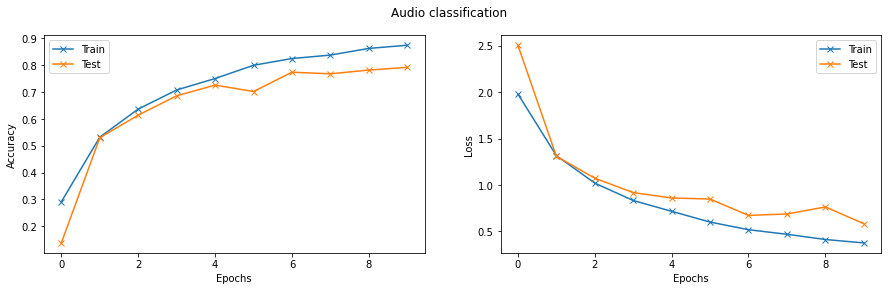

In [18]:
fig = plt.figure(figsize=(15, 4))
fig.suptitle('Audio classification')
# accuraccy
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.array(train_logs['acc']), '-x', label="Train")
ax.plot(np.array(val_logs['acc']), '-x', label="Test")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
# loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.array(train_logs['loss']), '-x', label="Train")
ax.plot(np.array(val_logs['loss']), '-x', label="Test")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

### Prediction

In [21]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = resample_transform(tensor)
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = tensor.argmax(dim=-1).squeeze()
    tensor = index_to_label(tensor.squeeze())
    return tensor

In [22]:
waveform, sample_rate, utterance, *_ = train_db[-1]
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)

Expected: zero. Predicted: zero.


## Excercises

Below is a list of exercises to practice what we have learnt in this notebook:
1. Visualise the kernels of the first layer, do they resemble any neurons of the auditory cortex?

## References

The following sources inspire the materials in this notebook:
1. [PyTorch torchaudio tutorial](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html)